In [2]:
from gensim.models import Word2Vec
import numpy as np
from sklearn.model_selection import KFold
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed
from tensorflow.keras.optimizers import Adam

In [3]:
import numpy as np
import pandas as pd
from gensim.models.word2vec import Word2Vec
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.layers import Dense, Dropout, Conv1D, MaxPool1D, GlobalMaxPool1D, Embedding, Activation
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
import re
from sklearn import preprocessing

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from scipy import misc

import os
import time

from sklearn.metrics import classification_report, confusion_matrix

In [4]:
df = pd.read_excel("/content/drive/MyDrive/RISET-SKRIPSI/FEBI RISET/PRE+PELABELAN/hasil_cluster_pre.xlsx")

In [5]:
df = df.dropna()
df = df.reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10017 entries, 0 to 10016
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   No            10017 non-null  int64 
 1   Ulasan        10017 non-null  object
 2   Cleaning      10017 non-null  object
 3   CaseFolding   10017 non-null  object
 4   Tokenization  10017 non-null  object
 5   Normalisasi   10017 non-null  object
 6   Stopword      10017 non-null  object
 7   Stemming      10017 non-null  object
 8   Positif       10017 non-null  int64 
 9   Negatif       10017 non-null  int64 
 10  Cluster       10017 non-null  int64 
dtypes: int64(4), object(7)
memory usage: 861.0+ KB


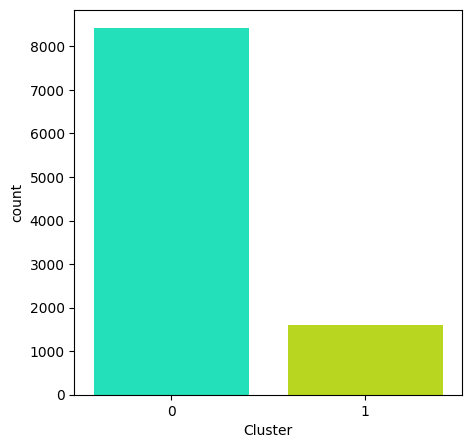

In [6]:
plt.figure(figsize=(5,5))
colors = ['#04FFCD','#CCF500']
sns.countplot(x='Cluster',data=df,palette=colors)
plt.show()

In [7]:
data=df['Stemming']
dokumen=data.to_list()
for i in range (len(dokumen)):
 dokumen[i]=dokumen[i]
 dokumen[i]=dokumen[i].replace("[","")
 dokumen[i]=dokumen[i].replace("]","")
 dokumen[i]=dokumen[i].replace("'","")
 dokumen[i]=dokumen[i].replace(",","")
 dokumen[i]=dokumen[i].split()
dokumen

[['pantai',
  'indah',
  'cocok',
  'keluarga',
  'santa',
  'nikmat',
  'debur',
  'ombak',
  'sayang',
  'kali',
  'ketemu',
  'mobil',
  'soundystem',
  'yag',
  'putar',
  'keras',
  'rusak',
  'syahdu',
  'moga',
  'tertib',
  'masyarakat'],
 ['tolong',
  'tingkat',
  'pakai',
  'motor',
  'pintu',
  'masuk',
  'loket',
  'tera',
  'include',
  'parkir',
  '5rb',
  'sampa',
  'loket',
  'portal',
  'pas',
  'tikung',
  'belok',
  'kanan',
  'suruh',
  'bayar',
  '5rb',
  'wajib',
  'parkir',
  'motor',
  'situ'],
 ['pantai',
  'malang',
  'selatan',
  'fasilitas',
  'lengkap',
  'rumah',
  'makan',
  'musholla',
  'inap',
  'toilet',
  'akses',
  'internet',
  'lancar',
  'camping',
  'tenda',
  'khawatir',
  'sewa',
  'pantai',
  'ramai',
  'foto2',
  'noise',
  'baik',
  'weekdays',
  'weekend',
  'ramai',
  'unjung'],
 ['lumayan',
  'inap',
  'camping',
  'bintang',
  'cuaca',
  'cerah',
  'jual',
  'makan',
  'minum',
  'harga',
  'lumayan',
  'jangkau'],
 ['akses',
  'jalan',

In [8]:
word2vec_model = Word2Vec(dokumen, vector_size=100, window=5, sg=1, min_count=1, workers=3)
print(word2vec_model)

Word2Vec<vocab=8349, vector_size=100, alpha=0.025>


In [9]:
token = Tokenizer(2663)
token.fit_on_texts(df['Stemming'])
text = token.texts_to_sequences(df['Stemming'])
text = pad_sequences(text, 100)

In [10]:
le = preprocessing.LabelEncoder()
y = le.fit_transform(df['Cluster'])
y = to_categorical(y)
y[:10]

array([[0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [11]:
x_train, x_test, y_train, y_test = train_test_split(np.array(text), y, test_size=0.2, stratify=y)

In [12]:
len(x_train)

8013

In [13]:
from gensim.models.keyedvectors import KeyedVectors
from keras.layers import Embedding
from tensorflow.keras.layers import Embedding

def gensim_to_keras_embedding(model, train_embeddings=False):
    """Get a Keras 'Embedding' layer with weights set from Word2Vec model's learned word embeddings.

    Parameters
    ----------
    train_embeddings : bool
        If False, the returned weights are frozen and stopped from being updated.
        If True, the weights can / will be further updated in Keras.

    Returns
    -------
    `keras.layers.Embedding`
        Embedding layer, to be used as input to deeper network layers.

    """
    keyed_vectors = model.wv  # structure holding the result of training
    weights = keyed_vectors.vectors  # vectors themselves, a 2D numpy array
    index_to_key = keyed_vectors.index_to_key  # which row in `weights` corresponds to which word?

    layer = Embedding(
        input_dim=weights.shape[0],
        output_dim=weights.shape[1],
        weights=[weights],
        trainable=train_embeddings,
    )
    return layer

In [14]:
def LSTM_model():
    model = Sequential()
    model.add(gensim_to_keras_embedding(word2vec_model))
    model.add(LSTM(100))
    model.add(Dense(2, activation='softmax'))
    model.add(Dropout(0.2))  # Menambahkan lapisan Dropout
    optimizer = Adam(learning_rate=0.001)

    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [15]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

pat = 5 #this is the number of epochs with no improvment after which the training will stop
early_stopping = EarlyStopping(monitor='val_loss', patience=pat, verbose=1)

model_checkpoint = ModelCheckpoint('window5.h5', verbose=1, save_best_only=True)

#define a function to fit the model
def fit_and_evaluate(t_x, val_x, t_y, val_y, EPOCHS=25, BATCH_SIZE=128):
    model = None
    model = LSTM_model()
    results = model.fit(t_x, t_y, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[early_stopping, model_checkpoint],
              verbose=1, validation_data=(x_test, y_test))
    print("Val Score: ", model.evaluate(val_x, val_y))
    return results

In [16]:
def draw_confusion_matrix(true,preds):
    conf_matx = confusion_matrix(true, preds)
    sns.heatmap(conf_matx, annot=True,annot_kws={"size": 12},fmt='g', cbar=False, cmap="Oranges")
    plt.show()
    #return conf_matx

In [ ]:
n_folds=10
epochs=25
batch_size=128


#save the model history in a list after fitting so that we can plot later
model_history = []

for i in range(n_folds):
    print("Training on Fold: ",i+1)
    t_x, val_x, t_y, val_y = train_test_split(x_train, y_train, test_size=0.2,
                                               random_state = np.random.randint(1,1000, 1)[0])
    model_history.append(fit_and_evaluate(t_x, val_x, t_y, val_y, epochs, batch_size))
    print("======="*12, end="\n\n\n")

Training on Fold:  1
Epoch 1/25
51/51 [==============================] - ETA: 0s - loss: nan - accuracy: 0.7381
Epoch 1: val_loss improved from inf to 0.19703, saving model to window5.h5
51/51 [==============================] - 16s 259ms/step - loss: nan - accuracy: 0.7381 - val_loss: 0.1970 - val_accuracy: 0.9082
Epoch 2/25


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


50/51 [============================>.] - ETA: 0s - loss: nan - accuracy: 0.7731
Epoch 2: val_loss improved from 0.19703 to 0.18929, saving model to window5.h5
51/51 [==============================] - 11s 223ms/step - loss: nan - accuracy: 0.7732 - val_loss: 0.1893 - val_accuracy: 0.9082
Epoch 3/25
50/51 [============================>.] - ETA: 0s - loss: nan - accuracy: 0.7742
Epoch 3: val_loss did not improve from 0.18929
51/51 [==============================] - 14s 266ms/step - loss: nan - accuracy: 0.7744 - val_loss: 0.2005 - val_accuracy: 0.8982
Epoch 4/25
50/51 [============================>.] - ETA: 0s - loss: nan - accuracy: 0.7763
Epoch 4: val_loss did not improve from 0.18929
51/51 [==============================] - 14s 283ms/step - loss: nan - accuracy: 0.7763 - val_loss: 0.1897 - val_accuracy: 0.9092
Epoch 5/25
51/51 [==============================] - ETA: 0s - loss: nan - accuracy: 0.7788
Epoch 5: val_loss improved from 0.18929 to 0.18316, saving model to window5.h5
51/51 [=

In [ ]:
from keras.models import load_model

# Load the saved model
saved_model = load_model('window5.h5')

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score

# Model telah dilatih sebelumnya, maka lakukan prediksi pada data uji
predictions = saved_model.predict(x_test)

# Ambil label prediksi (diasumsikan bentuk keluaran model adalah one-hot encoded)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_test, axis=1)

# Hitung confusion matrix
bm = confusion_matrix(true_labels, predicted_labels)
bm
# Hitung dan tampilkan akurasi
scc = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {scc}")

In [ ]:
draw_confusion_matrix(true_labels, predicted_labels)

In [ ]:
bm

In [ ]:
plt.title('accuracies vs Epochs')
plt.plot(model_history[0].history['accuracy'], label='Fold 1')
plt.plot(model_history[1].history['accuracy'], label='Fold 2')
plt.plot(model_history[2].history['accuracy'], label='Fold 3')
plt.plot(model_history[3].history['accuracy'], label='Fold 4')
plt.plot(model_history[4].history['accuracy'], label='Fold 5')
plt.plot(model_history[5].history['accuracy'], label='Fold 6')
plt.plot(model_history[6].history['accuracy'], label='Fold 7')
plt.plot(model_history[7].history['accuracy'], label='Fold 8')
plt.plot(model_history[8].history['accuracy'], label='Fold 9')
plt.plot(model_history[9].history['accuracy'], label='Fold 10')
plt.legend()
plt.show()

In [ ]:
model_history[9].history['accuracy']

In [ ]:
fig, axs = plt.subplots(5, 2, constrained_layout=True)
axs[0, 0].plot(model_history[0].history['accuracy'])
axs[0, 0].set_title('Training Fold 1')
axs[0, 1].plot(model_history[1].history['accuracy'])
axs[0, 1].set_title('Training Fold 2')
axs[1, 0].plot(model_history[2].history['accuracy'])
axs[1, 0].set_title('Training Fold 3')
axs[1, 1].plot(model_history[3].history['accuracy'])
axs[1, 1].set_title('Training Fold 4')
axs[2, 0].plot(model_history[4].history['accuracy'])
axs[2, 0].set_title('Training Fold 5')
axs[2, 1].plot(model_history[5].history['accuracy'])
axs[2, 1].set_title('Training Fold 6')
axs[3, 0].plot(model_history[6].history['accuracy'])
axs[3, 0].set_title('Training Fold 7')
axs[3, 1].plot(model_history[7].history['accuracy'])
axs[3, 1].set_title('Training Fold 8')
axs[4, 0].plot(model_history[8].history['accuracy'])
axs[4, 0].set_title('Training Fold 9')
axs[4, 1].plot(model_history[9].history['accuracy'])
axs[4, 1].set_title('Training Fold 10')

for ax in axs.flat:
    ax.set(xlabel='epoch', ylabel='akurasi')

In [ ]:
plt.title('Train Accuracy vs Val Accuracy')
plt.plot(model_history[0].history['accuracy'], label='Train Accuracy Fold 1', color='black')
plt.plot(model_history[0].history['val_accuracy'], label='Val Accuracy Fold 1', color='black', linestyle = "dashdot")
plt.plot(model_history[1].history['accuracy'], label='Train Accuracy Fold 2', color='red', )
plt.plot(model_history[1].history['val_accuracy'], label='Val Accuracy Fold 2', color='red', linestyle = "dashdot")
plt.plot(model_history[2].history['accuracy'], label='Train Accuracy Fold 3', color='green', )
plt.plot(model_history[2].history['val_accuracy'], label='Val Accuracy Fold 3', color='green', linestyle = "dashdot")
plt.legend()
plt.show()

In [ ]:
fig, axs = plt.subplots(5, 2, constrained_layout=True)
axs[0, 0].plot(model_history[0].history['accuracy'],model_history[0].history['val_accuracy'])
axs[0, 0].set_title('Training Fold 1')
axs[0, 1].plot(model_history[1].history['accuracy'],model_history[1].history['val_accuracy'])
axs[0, 1].set_title('Training Fold 2')
axs[1, 0].plot(model_history[2].history['accuracy'],model_history[2].history['val_accuracy'])
axs[1, 0].set_title('Training Fold 3')
axs[1, 1].plot(model_history[3].history['accuracy'],model_history[3].history['val_accuracy'])
axs[1, 1].set_title('Training Fold 4')
axs[2, 0].plot(model_history[4].history['accuracy'],model_history[4].history['val_accuracy'])
axs[2, 0].set_title('Training Fold 5')
axs[2, 1].plot(model_history[5].history['accuracy'],model_history[5].history['val_accuracy'])
axs[2, 1].set_title('Training Fold 6')
axs[3, 0].plot(model_history[6].history['accuracy'],model_history[6].history['val_accuracy'])
axs[3, 0].set_title('Training Fold 7')
axs[3, 1].plot(model_history[7].history['accuracy'],model_history[7].history['val_accuracy'])
axs[3, 1].set_title('Training Fold 8')
axs[4, 0].plot(model_history[8].history['accuracy'],model_history[8].history['val_accuracy'])
axs[4, 0].set_title('Training Fold 9')
axs[4, 1].plot(model_history[9].history['accuracy'],model_history[9].history['val_accuracy'])
axs[4, 1].set_title('Training Fold 10')

for ax in axs.flat:
    ax.set(xlabel='Acc', ylabel='val acc')

In [ ]:
model=model_history
n=len(model)
accuracy=[]
for i in range (n):
    akurasi=0
    model1=model[i].history['accuracy']
    for j in range (len(model1)):
        akurasi += model1[j]
    akurasi=akurasi/len(model1)
    accuracy.append(akurasi)

In [ ]:
accuracy

In [ ]:
acc=0
for i in range(len(accuracy)):
    acc+=accuracy[i]
average=acc/(len(accuracy))
average

In [ ]:
FEtime

In [ ]:
CNNTime